In [19]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import joblib
import os

In [2]:
def find_backend_dir(start_path=None):
    """
    Walk up directories from start_path (or cwd) until a folder named 'backend' is found.
    Returns the absolute path to the 'backend' folder.
    """
    if start_path is None:
        start_path = os.getcwd()
    curr_path = os.path.abspath(start_path)
    while True:
        # Check if 'backend' exists in this directory
        candidate = os.path.join(curr_path, "backend")
        if os.path.isdir(candidate):
            return candidate
        # If at filesystem root, stop
        parent = os.path.dirname(curr_path)
        if curr_path == parent:
            break
        curr_path = parent
    raise FileNotFoundError(f"No 'backend' directory found upward from {start_path}")

# Find the backend directory and CSV folder
backend_dir = find_backend_dir()
csv_dir = os.path.join(backend_dir, "CSVs")
models_dir = os.path.join(backend_dir, "Models")

In [3]:
# 1. Load your season-level data
train = pd.read_csv(csv_dir+"/train_season_features.csv")
test  = pd.read_csv(csv_dir+"/test_season_features.csv")

In [4]:
target_cols  = [c for c in train.columns if c.startswith("next_")]
feature_cols = [c for c in train.columns if c not in ["PERSON_ID","SEASON_ID"] + target_cols]



In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    train[feature_cols], train[target_cols], test_size=0.2, random_state=42
)
X_test, y_test = test[feature_cols], test[target_cols]

In [6]:
# Replace all inf/-inf with NaN for ALL splits
for df_ in [X_train, X_val, y_train, y_val, X_test, y_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

/var/folders/8z/yxhm1c6x4bvg_s6d6w0cl6_80000gn/T/ipykernel_6073/3105461840.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_.replace([np.inf, -np.inf], np.nan, inplace=True)


In [7]:
# # 2. Impute any missing values
imputer = SimpleImputer(strategy="median")
# X_train = imp.fit_transform(X_train)
# X_val   = imp.transform(X_val)
# X_test  = imp.transform(X_test)

In [8]:
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns, index=X_val.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

y_train_imputed = pd.DataFrame(imputer.fit_transform(y_train), columns=y_train.columns, index=y_train.index)
y_val_imputed = pd.DataFrame(imputer.transform(y_val), columns=y_val.columns, index=y_val.index)
y_test_imputed = pd.DataFrame(imputer.transform(y_test), columns=y_test.columns, index=y_test.index)


In [9]:
# 3. Build the XGBoost multi-output regressor
xgb = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    )
)

In [10]:
# 4. Train
xgb.fit(X_train_imputed, y_train_imputed)


,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None


In [11]:
# 5. Evaluate
val_pred  = xgb.predict(X_val_imputed)
test_pred = xgb.predict(X_test_imputed)

In [12]:
print("XGBoost Validation MAE:", round(mean_absolute_error(y_val_imputed, val_pred),3),
      "R2:", round(r2_score(y_val_imputed, val_pred),3))
print("XGBoost    Test MAE:", round(mean_absolute_error(y_test_imputed, test_pred),3),
      "R2:", round(r2_score(y_test_imputed, test_pred),3))

XGBoost Validation MAE: 1.932 R2: 0.682
XGBoost    Test MAE: 2.05 R2: 0.647


In [13]:
lgbm = MultiOutputRegressor(
    lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42, force_col_wise=True)
)
lgbm.fit(X_train_imputed, y_train_imputed)

[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 12.999126
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 2.207877
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 2.805022
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 4.749272
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 10.110117
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529,

,estimator,LGBMRegressor...ndom_state=42)
,n_jobs,None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


In [14]:
# Evaluate
pred_val  = lgbm.predict(X_val_imputed)
print("LightGBM MAE:", round(mean_absolute_error(y_val_imputed, pred_val),3),
      "R²:", round(r2_score(y_val_imputed, pred_val),3))

LightGBM MAE: 1.991 R²: 0.663


In [15]:
single_target = "next_Points"
y_train_single = y_train_imputed[single_target]
y_val_single = y_val_imputed[single_target]

param_dist = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 5, 6, 8],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}
xgb = XGBRegressor(random_state=42, verbosity=0)
search = RandomizedSearchCV(
    xgb, param_dist, n_iter=16, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42
)
search.fit(X_train_imputed, y_train_single)
print("Best XGBoost Params:", search.best_params_)


Best XGBoost Params: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.7}


In [16]:
best_xgb = MultiOutputRegressor(XGBRegressor(**search.best_params_, random_state=42, verbosity=0))
best_xgb.fit(X_train_imputed, y_train_imputed)

,estimator,"XGBRegressor(...ree=None, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None


In [20]:
param_dist_lgb = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.03, 0.05, 0.1],
    "max_depth": [3, 5, 7, -1],
    "num_leaves": [16, 31, 50, 100],
    "feature_fraction": [0.7, 0.8, 1.0],
}
lgbm = LGBMRegressor(random_state=42)
search_lgb = RandomizedSearchCV(
    lgbm, param_dist_lgb, n_iter=16, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1, random_state=42
)
search_lgb.fit(X_train_imputed, y_train_single)
print("Best LightGBM Params:", search_lgb.best_params_)

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGB

In [21]:
best_lgbm = MultiOutputRegressor(LGBMRegressor(**search_lgb.best_params_, random_state=42))
best_lgbm.fit(X_train_imputed, y_train_imputed)

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11545
[LightGBM] [Info] Number of data points in the train set: 1529, number of used features: 53
[LightGBM] [Info] Start training from score 12.999126
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_

,estimator,LGBMRegressor...ndom_state=42)
,n_jobs,None
,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.01
,n_estimators,300
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0


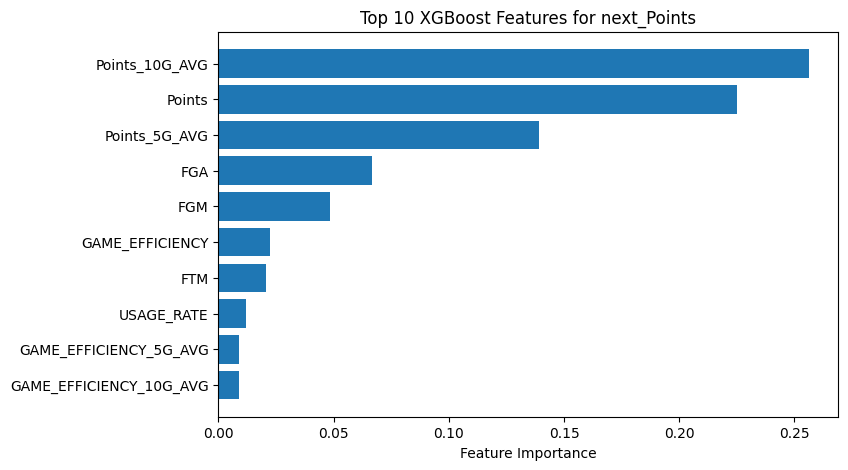

In [22]:
first_xgb = best_xgb.estimators_[0]  # For next_Points
importances = first_xgb.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10
plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_cols)[indices[:top_n]][::-1], importances[indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 XGBoost Features for next_Points")
plt.show()

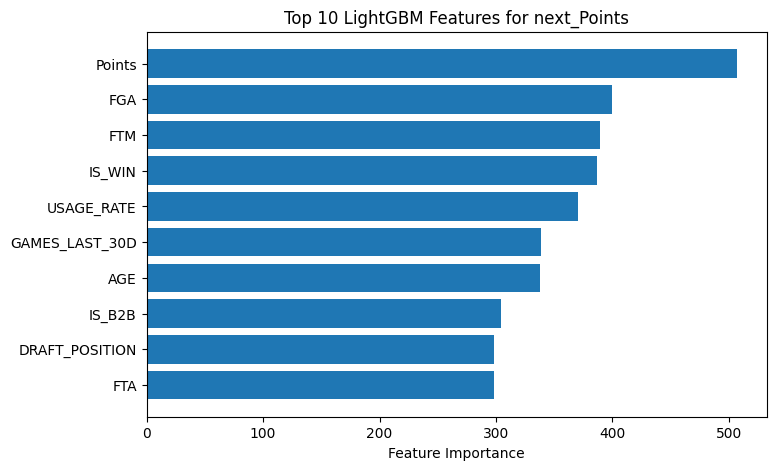

In [23]:
first_lgb = best_lgbm.estimators_[0]
importances = first_lgb.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(8, 5))
plt.barh(np.array(feature_cols)[indices[:top_n]][::-1], importances[indices[:top_n]][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 LightGBM Features for next_Points")
plt.show()

In [24]:
def print_per_target_metrics(y_true, y_pred, target_cols):
    for i, col in enumerate(target_cols):
        print(f"{col:>12}  MAE: {mean_absolute_error(y_true.iloc[:, i], y_pred[:, i]):.3f}  R²: {r2_score(y_true.iloc[:, i], y_pred[:, i]):.3f}")

print("XGBoost Val Metrics:")
print_per_target_metrics(y_val_imputed, best_xgb.predict(X_val_imputed), target_cols)
print("\nLightGBM Val Metrics:")
print_per_target_metrics(y_val_imputed, best_lgbm.predict(X_val_imputed), target_cols)


XGBoost Val Metrics:
 next_Points  MAE: 2.340  R²: 0.811
    next_FTM  MAE: 0.590  R²: 0.773
    next_FTA  MAE: 0.682  R²: 0.786
    next_FGM  MAE: 0.866  R²: 0.796
    next_FGA  MAE: 1.710  R²: 0.811
     next_TO  MAE: 0.180  R²: 0.658
    next_STL  MAE: 0.155  R²: 0.679
    next_BLK  MAE: 0.331  R²: 0.751
     next_PF  MAE: 0.356  R²: 0.521
next_USAGE_RATE  MAE: 4.816  R²: 0.718
   next_OREB  MAE: 0.259  R²: 0.786
   next_DREB  MAE: 0.733  R²: 0.739
    next_AST  MAE: 0.615  R²: 0.839
    next_REB  MAE: 0.891  R²: 0.764
next_Minutes  MAE: 3.375  R²: 0.679
    next_3PM  MAE: 0.334  R²: 0.788
    next_3PA  MAE: 0.817  R²: 0.800
    next_3P%  MAE: 6.415  R²: 0.123
    next_FT%  MAE: 6.092  R²: 0.375
    next_FG%  MAE: 3.551  R²: 0.591
next_GAME_EFFICIENCY  MAE: 4.383  R²: 0.807

LightGBM Val Metrics:
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytre

In [25]:
joblib.dump(best_xgb, models_dir + "/xgboost_multioutput_tuned_model.joblib")
joblib.dump(best_lgbm, models_dir + "/lightgbm_multioutput_tuned_model.joblib")

['/Users/jeevanparmar/Uni/MSE 436/Project-Mono-Repo/backend/Models/lightgbm_multioutput_tuned_model.joblib']